# BBC news clasification

## Matrix factorization

### Unsupervised Algorithms in Machine Learning

This notebook is part of the week 4 project of the course Unsupervised Algorithms in Machine Learning from the University of Colorado Boulder and tackles the BBC news classification competition from <a href="https://www.kaggle.com/competitions/learn-ai-bbc/data">kaggle</a> using matrix factorization for multiple tasks. <br>
The document is divided in the following sections:
* Introduction
* Exploratory Data Analysis and preprocessing
* Baseline model
* Matrix factorization
* Final model and submision
* Conclusions
* References

### Introduction

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from itertools import permutations
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import time

In [2]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

Data import

In [3]:
train_loc = "/kaggle/input/learn-ai-bbc/BBC News Train.csv"
test_loc = "/kaggle/input/learn-ai-bbc/BBC News Test.csv"

<IPython.core.display.Javascript object>

In order to run this notebook locally uncomment the following cell, dowload the <a href="https://www.kaggle.com/competitions/learn-ai-bbc/data">data</a> from kaggle and save it in a folder named Data beside Notebooks.

In [4]:
# train_loc = "../Data/BBC News Train.csv"
# test_loc = "../Data/BBC News Test.csv"

<IPython.core.display.Javascript object>

In [5]:
train = pd.read_csv(train_loc)
test = pd.read_csv(test_loc)

<IPython.core.display.Javascript object>

Constants

In [6]:
np.random.seed(42)

<IPython.core.display.Javascript object>

In [7]:
N_NEIGH_LIST = list(range(2, 20)) + [
    22,
    25,
    27,
    30,
    35,
    40,
    50,
    75,
    100,
    150,
    200,
]

<IPython.core.display.Javascript object>

### Exploratory Data Analysis and preprocessing

In [8]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


<IPython.core.display.Javascript object>

As we can see in the following plot the category labels are balanced.

<AxesSubplot:xlabel='Category', ylabel='Count'>

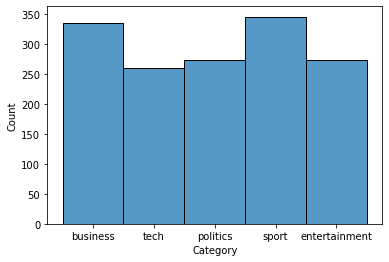

<IPython.core.display.Javascript object>

In [9]:
sns.histplot(train["Category"])

Text is a challenging data source for machine learning algorithms because of its complexity and lack of structure. The problem of converting text articles into numerical vectors so that classification models can be applied is very challenging and needs to be done in a way such that:
* Important information of the text is captured
* The codification is efficient (non relevant information is discarded)
* The resultant dimensionality is manageable
* Computation and memory consumption is not an issue

These challanges will be addressed by various preprocessing steps including standarization, puntuation and stopword removal, and the use of Term Frequency - Inverse Document Frequency vectorization.

Delete punctuation signs and transform into lowercase

In [10]:
train["Text"] = train["Text"].apply(
    lambda x: "".join([s.lower() for s in x if s not in string.punctuation])
)
test["Text"] = test["Text"].apply(
    lambda x: "".join([s for s in x if s not in string.punctuation])
)

<IPython.core.display.Javascript object>

Tockenization

In [11]:
train["Text"] = train["Text"].apply(lambda x: x.split(" "))
test["Text"] = test["Text"].apply(lambda x: x.split(" "))

<IPython.core.display.Javascript object>

Delete stopwords

In [12]:
# nltk.download('stopwords')

<IPython.core.display.Javascript object>

In [13]:
stopwords = nltk.corpus.stopwords.words("english")

<IPython.core.display.Javascript object>

In [14]:
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]

<IPython.core.display.Javascript object>

In [15]:
train["Text"] = train["Text"].apply(lambda t: [w for w in t if w not in stopwords])
test["Text"] = test["Text"].apply(lambda t: [w for w in t if w not in stopwords])

<IPython.core.display.Javascript object>

Lenght of text attribute

In [16]:
train["length"] = train["Text"].apply(len)

<IPython.core.display.Javascript object>

In [17]:
test["length"] = test["Text"].apply(len)

<IPython.core.display.Javascript object>

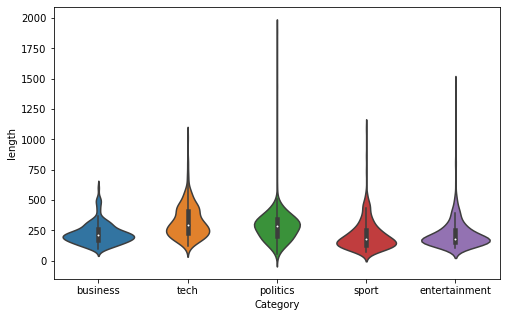

<IPython.core.display.Javascript object>

In [18]:
sns.violinplot(data=train, y="length", x="Category")
fig = plt.gcf()
fig.set_size_inches(8, 5)

In [19]:
classes = train["Category"].unique()

<IPython.core.display.Javascript object>

Train and test split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    train.drop("Category", axis=1), train["Category"], test_size=0.25
)

<IPython.core.display.Javascript object>

The final step to prepare the articles for the machine learning algorithms is to use the TfIdf vectorization. This technique produces a vector $v=\lambda(v_1,v_2,\dots ,v_n)$ for each article where each entry attempts to represent the importance of a specific term in the text and is calculated according to the next formula (there are other similar definitions with subtle differences):
$$
v_i = TF*IDF = \text{Number of appereances of word }i*log\Big(\frac{\text{Number of documents}+1}{\text{Number of documents were word }i\text{ appears}+1}+1\Big)
$$
The left side of the multiplication is bigger as the prevalence of the word increases and the right side of the weights more heavily rare terms. Finally, the $\lambda$ parameter normalizes the vector to norm 1 so that all outputs have the same l2 length.

In [21]:
vectorizer = TfidfVectorizer()

<IPython.core.display.Javascript object>

In [22]:
x_train_vectorized = np.array(
    vectorizer.fit_transform(x_train["Text"].apply(lambda x: " ".join(x))).todense()
)

<IPython.core.display.Javascript object>

In [23]:
x_test_vectorized = np.array(
    vectorizer.transform(x_test["Text"].apply(lambda x: " ".join(x))).todense()
)


<IPython.core.display.Javascript object>

In [24]:
x_test_kaggle = np.array(
    vectorizer.transform(test["Text"].apply(lambda x: " ".join(x))).todense()
)


<IPython.core.display.Javascript object>

Now that we have a vectorized representation of the articles let's use matrix factorization for dimensionality reduction in order to visualize the different texts and their respective labels

In [25]:
sklearn_svd = TruncatedSVD(n_components=2)

<IPython.core.display.Javascript object>

In [26]:
x_train_2d = sklearn_svd.fit_transform(x_train_vectorized)

<IPython.core.display.Javascript object>

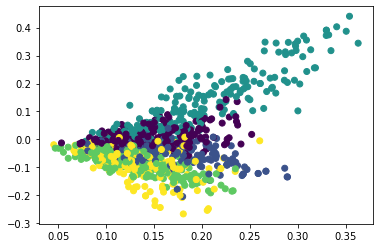

<IPython.core.display.Javascript object>

In [27]:
fig, ax = plt.subplots()
ax.scatter(
    x_train_2d[:, 0],
    x_train_2d[:, 1],
    c=y_train.apply(lambda x: list(classes).index(x)),
)

The plot above shows a 2D representation of the articles and their labels, and exposes that there are considerable differences between the different classes.

### Baseline model

Now let's construct a baseline classification model using the K Nearest Neighbors algorithm.

In [28]:
knn = KNeighborsClassifier()

<IPython.core.display.Javascript object>

In [29]:
knn_gridcv = GridSearchCV(knn, param_grid={"n_neighbors": N_NEIGH_LIST},)

<IPython.core.display.Javascript object>

Cross validation

In [30]:
knn_gridcv.fit(x_train_vectorized, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 22, 25, 27, 30,
                                         35, 40, 50, 75, 100, 150, 200]})

<IPython.core.display.Javascript object>

In [31]:
knn = knn_gridcv.best_estimator_
knn_gridcv.best_estimator_

KNeighborsClassifier(n_neighbors=40)

<IPython.core.display.Javascript object>

In [32]:
knn_gridcv.best_score_

0.9453955797565662

<IPython.core.display.Javascript object>

Test metrics

In [33]:
y_test_pred = knn.predict(x_test_vectorized)

<IPython.core.display.Javascript object>

In [34]:
y_test_pred_proba = knn.predict_proba(x_test_vectorized)

<IPython.core.display.Javascript object>

In [35]:
accuracy_score(y_test, y_test_pred)

0.967828418230563

<IPython.core.display.Javascript object>

The train and test accuracy, and the following ROC plots, reveal that the KNN model has strong predictive power and extrapolates well to unseen data.

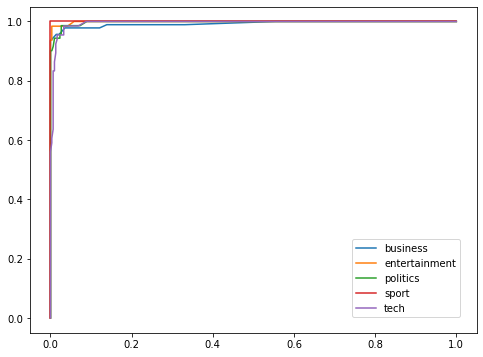

<IPython.core.display.Javascript object>

In [36]:
fig, ax = plt.subplots()
for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(
        (y_test == knn.classes_[i]).astype(int), y_test_pred_proba[:, i]
    )
    ax.plot(fpr, tpr)
fig.legend(labels=knn.classes_, loc=4, bbox_to_anchor=(0.88, 0.15))
fig.set_size_inches(8, 6)

### Non negative matrix factorization

The course assignment requires to test matrix factorization as an unsupervised approach for the classification problem, so the TruncatedSVD class of sklearn will be used to extract 5 features from the texts. Every data instance is then assigned to feature of greater value and then, each of these 5 features will be assigned to a data label by maximizing the accuracy on the training set over all feature permutations. 

In [37]:
sklearn_svd = TruncatedSVD(n_components=5)

<IPython.core.display.Javascript object>

In [38]:
pred_train_svd = np.argmax(sklearn_svd.fit_transform(x_train_vectorized), axis=1)

<IPython.core.display.Javascript object>

In [39]:
pred_test_svd = np.argmax(sklearn_svd.transform(x_test_vectorized), axis=1)

<IPython.core.display.Javascript object>

Finds best permutation for labels

In [40]:
def perm_acc_nmf(classes, pred_train_svd, y_train):
    perm_final = None
    acc_final = 0
    for p in permutations(classes):
        pred_train_svd_label = [p[i] for i in pred_train_svd]
        acc_score = accuracy_score(y_train.values, pred_train_svd_label)
        if acc_score > acc_final:
            perm_final = p
            acc_final = acc_score
    return perm_final, acc_final

<IPython.core.display.Javascript object>

In [41]:
perm_final, acc_final = perm_acc_nmf(classes, pred_train_svd, y_train)

<IPython.core.display.Javascript object>

In [42]:
perm_final

('sport', 'politics', 'tech', 'entertainment', 'business')

<IPython.core.display.Javascript object>

Final metrics over train and test set

In [43]:
acc_final

0.4297224709042077

<IPython.core.display.Javascript object>

In [44]:
pred_test_svd_label = [perm_final[i] for i in pred_test_svd]
accuracy_score(y_test.values, pred_test_svd_label)

0.4075067024128686

<IPython.core.display.Javascript object>

The resulting accuracies show that the model has some predictive power, as random choice would result in 20% accuracy, but is far worse than the baseline model previously fitted. Matrix factorization can also be used as a preprocessing step for dimentionality reduction. This might be very valuable as TfIdf vectorization produces vectors with the same length as the vocaculary.

In order to fully understand these three methods and how they compare to each other, a more exhaustive comparison will be constructed by fitting the three models in different subsets of the data and recording statistics like accuracy and training time.

In [45]:
n_components_test = [2, 5, 10, 20, 50, 100]
table_cols = [
    "Sample",
    "knn_test",
    "knn_time",
    "knn_time_pred",
    "svd_test",
    "svd_time",
    "svd_time_pred",
    f"svd_knn_test",
    f"svd_knn_time",
    f"svd_knn_time_pred",
    "k",
    "dims",
]
table_comp_svd_knn = pd.DataFrame(columns=table_cols)

<IPython.core.display.Javascript object>

In [46]:
knn_sample = KNeighborsClassifier()
n_sims = 10
for i in range(n_sims):
    print(i)
    # Data prep
    y_train_sim = y_train.iloc[: int(len(y_train) * (i + 1) / (n_sims))]
    x_train_vectorized_sim = x_train_vectorized[
        : int(len(y_train) * (i + 1) / (n_sims)), :
    ]
    # KNN
    knn_gridcv_sample = GridSearchCV(
        knn_sample,
        param_grid={
            "n_neighbors": [n for n in N_NEIGH_LIST if n * 5 / 4 < len(y_train_sim)]
        },
    )
    t0 = time.time_ns()
    knn_gridcv_sample.fit(x_train_vectorized_sim, y_train_sim)
    knn_sample = knn_gridcv_sample.best_estimator_
    t0_pred = time.time_ns()
    y_test_pred_sim = knn_sample.predict(x_test_vectorized)
    t1_pred = time.time_ns()
    knn_test_score = accuracy_score(y_test, y_test_pred_sim)
    t1 = time.time_ns()
    # SVD
    sklearn_svd_sim = TruncatedSVD(n_components=5)
    pred_train_svd_sim = np.argmax(
        sklearn_svd_sim.fit_transform(x_train_vectorized_sim), axis=1
    )
    perm_final_sim, svd_train_score = perm_acc_nmf(
        classes, pred_train_svd_sim, y_train_sim
    )
    t2_pred = time.time_ns()
    pred_test_svd_sim = np.argmax(sklearn_svd_sim.transform(x_test_vectorized), axis=1)
    pred_test_svd_label_sim = [perm_final_sim[i] for i in pred_test_svd_sim]
    t3_pred = time.time_ns()
    svd_test_score = accuracy_score(y_test.values, pred_test_svd_label_sim)
    t2 = time.time_ns()
    # SVD + KNN
    best_res = [0, None, None, None, None]
    for comp in n_components_test:
        sklearn_svd_sim = TruncatedSVD(n_components=comp)
        t0_comp = time.time_ns()
        train_svd_knn_sim = sklearn_svd_sim.fit_transform(x_train_vectorized_sim)
        knn_gridcv_sample.fit(train_svd_knn_sim, y_train_sim)
        knn_sample_comp = knn_gridcv_sample.best_estimator_
        t0_pred_comp = time.time_ns()
        x_test_vectorized_comp = sklearn_svd_sim.transform(x_test_vectorized)
        y_test_pred_sim = knn_sample_comp.predict(x_test_vectorized_comp)
        t1_pred_comp = time.time_ns()
        svd_knn_test_score = accuracy_score(y_test, y_test_pred_sim)
        t1_comp = time.time_ns()
        if svd_knn_test_score > best_res[0]:
            best_res = [
                svd_knn_test_score,
                (t1_comp - t0_comp) / 1000000,
                (t1_pred_comp - t0_pred_comp) / 1000000,
                knn_sample_comp.n_neighbors,
                comp,
            ]

    # Results
    table_comp_svd_knn.loc[i] = [
        (i + 1) / (n_sims),
        knn_test_score,
        (t1 - t0) / 1000000,
        (t1_pred - t0_pred) / 1000000,
        svd_test_score,
        (t2 - t1) / 1000000,
        (t3_pred - t2_pred) / 1000000,
    ] + best_res

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>

In [47]:
table_comp_svd_knn.set_index("Sample", inplace=True)

<IPython.core.display.Javascript object>

In [48]:
def line_plots(df, cols_to_plot, title="", x_label="Sample"):
    fig, ax = plt.subplots()
    ax.plot(df[cols_to_plot])
    ax.legend(cols_to_plot)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    return fig

<IPython.core.display.Javascript object>

The resulting model parameters from the cross validation of the composed model K and the number of dimensions, stay relatively stable around 10 while the size of the training set increases.

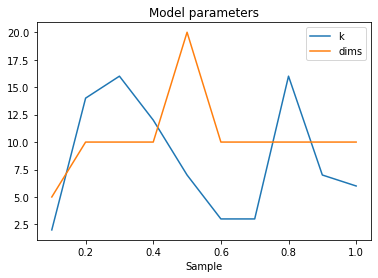

<IPython.core.display.Javascript object>

In [49]:
cols_to_plot = ["k", "dims"]
model_desc = line_plots(table_comp_svd_knn, cols_to_plot, "Model parameters")

The following plot shows that the test set accuracy of the composed model is similar to the accuracy of the KNN model after the training set grows to a critical size of around 30% of the dataset.

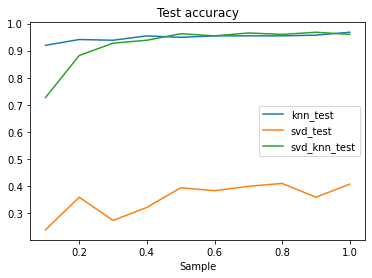

<IPython.core.display.Javascript object>

In [50]:
cols_to_plot = ["knn_test", "svd_test", "svd_knn_test"]
test_acc_fig = line_plots(table_comp_svd_knn, cols_to_plot, "Test accuracy")

While the accuracy of the composed model is similar to the accuracy of the KNN, the reduction in computational time is very large and grows larger as the dataset increases in size. The following two plots show one of the advantages of dimensionality reduction techniques.

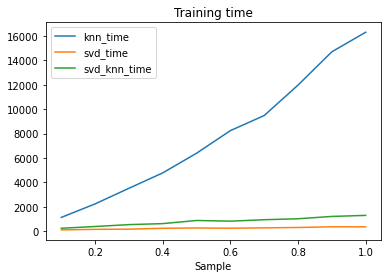

<IPython.core.display.Javascript object>

In [51]:
cols_to_plot = ["knn_time", "svd_time", "svd_knn_time"]
training_time_fig = line_plots(table_comp_svd_knn, cols_to_plot, "Training time")

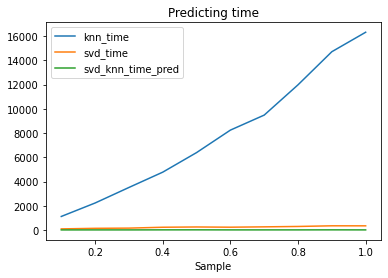

<IPython.core.display.Javascript object>

In [52]:
cols_to_plot = ["knn_time", "svd_time", "svd_knn_time_pred"]
training_time_fig = line_plots(table_comp_svd_knn, cols_to_plot, "Predicting time")

Best model

In [53]:
k, dim = tuple(table_comp_svd_knn.iloc[-1, -2:])

<IPython.core.display.Javascript object>

In [54]:
sklearn_svd = TruncatedSVD(n_components=int(dim))
train_svd_knn = sklearn_svd.fit_transform(x_train_vectorized)
knn = KNeighborsClassifier(n_neighbors=int(k))
knn.fit(train_svd_knn, y_train)
test_svd_knn = sklearn_svd.transform(x_test_vectorized)
test_svd_knn_kaggle = sklearn_svd.transform(x_test_kaggle)
y_train_pred = knn.predict(train_svd_knn)
y_test_pred = knn.predict(test_svd_knn)
svd_knn_test_score = accuracy_score(y_test, y_test_pred)

<IPython.core.display.Javascript object>

In [55]:
sklearn_svd

TruncatedSVD(n_components=10)

<IPython.core.display.Javascript object>

In [56]:
knn

KNeighborsClassifier(n_neighbors=6)

<IPython.core.display.Javascript object>

In [57]:
svd_knn_test_score

0.9571045576407506

<IPython.core.display.Javascript object>

In [58]:
y_test_pred_proba = knn.predict_proba(test_svd_knn)

<IPython.core.display.Javascript object>

The process outputs a model that achieves similar accuracy than the baseline model and is also considerably simpler and more efficient regarding computation and memory because of the dimensionality reduction.

### Final model and submission

In [59]:
print(
    f"""Final model: 
    Train accuracy  - {accuracy_score(y_train,y_train_pred):.2%}
    Test accuracy   - {accuracy_score(y_test, y_test_pred):.2%}
    Input dimension - {dim}
    K               - {k}
    """
)

Final model: 
    Train accuracy  - 95.43%
    Test accuracy   - 95.71%
    Input dimension - 10.0
    K               - 6.0
    


<IPython.core.display.Javascript object>

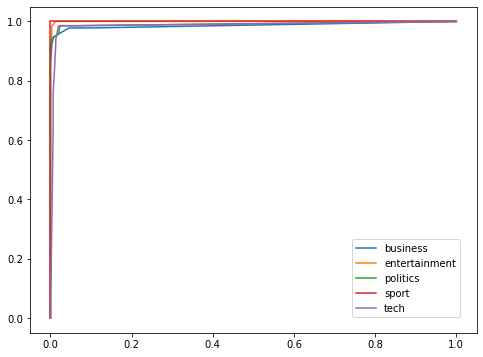

<IPython.core.display.Javascript object>

In [60]:
fig, ax = plt.subplots()
for i in range(len(knn.classes_)):
    fpr, tpr, _ = roc_curve(
        (y_test == knn.classes_[i]).astype(int), y_test_pred_proba[:, i]
    )
    ax.plot(fpr, tpr)
fig.legend(labels=knn.classes_, loc=4, bbox_to_anchor=(0.88, 0.15))
fig.set_size_inches(8, 6)

In [61]:
submission = test[["ArticleId"]].copy()

<IPython.core.display.Javascript object>

In [62]:
submission["Category"] = knn.predict(test_svd_knn_kaggle)

<IPython.core.display.Javascript object>

In [63]:
submission.to_csv("submission.csv", index=False)

<IPython.core.display.Javascript object>

### Conclusions

* Text data requires strong processing in order to achieve useful vector representations
* Matrix factorization is useful for dimensionality reduction
* Other models could be tested in order to improve accuracy

### References

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/